In [16]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [18]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [19]:
scores = scores[(scores != 0).all(1)]

In [20]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [21]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [22]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

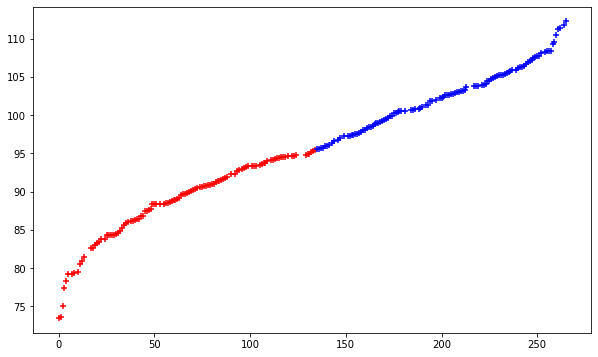

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [40]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])
display(preview_table)

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
0,Charleston,South Carolina,North America,0.404111,0.285222,0.435556,0.076849,0.644651,0.815902,0.428811,...,0.339214,0.704457,0.645634,0.307441,0.584328,0.621667,0.516777,0.606686,0.279083,worse
1,Knoxville,Tennessee,North America,0.663944,0.605222,0.279611,0.074702,0.193206,0.815902,0.437359,...,0.402996,0.295543,0.645634,0.390250,0.699002,0.388389,0.471896,0.168505,0.278432,worse
2,Jakarta,Indonesia,Asia,0.852333,0.830111,0.516611,0.193786,0.479305,0.172831,0.653497,...,0.057268,0.153109,0.416785,0.564497,0.401446,0.794000,0.065587,0.901655,0.285431,worse
3,Leipzig,Germany,Europe,0.797444,0.545667,0.189611,0.392186,0.879499,0.871497,0.685439,...,0.413256,0.906656,0.505022,0.288955,0.533100,0.391833,0.690031,0.571371,0.734543,better
4,Hamburg,Germany,Europe,0.549389,0.433778,0.532667,0.536868,0.847931,0.871497,0.590943,...,0.413256,0.802060,0.505022,0.288955,0.523233,0.594722,0.686316,0.617247,0.717456,better
188,Oslo,Norway,Europe,0.307556,0.004222,0.467667,0.482344,0.839290,0.949485,0.665743,...,0.504234,0.836618,0.714523,0.387917,0.799736,0.544333,0.670118,0.765438,0.614636,better
189,Toronto,Canada,North America,0.406667,0.474556,0.997889,0.391972,0.655146,0.856767,0.733553,...,0.771089,0.693120,0.562573,0.682120,0.388137,0.758444,0.779490,0.685322,0.841679,better
190,Seattle,Washington,North America,0.143444,0.310000,0.818556,0.236289,0.628298,0.815902,0.495928,...,0.566117,0.737174,0.645634,0.390250,0.452100,0.790611,0.799160,0.902664,0.422548,worse
192,Marseille,France,Europe,0.732056,0.558444,0.256611,0.565364,0.853705,0.735190,0.451510,...,0.427967,0.320721,0.360959,0.142524,0.521168,0.493667,0.565800,0.630096,0.546105,worse
193,Innsbruck,Austria,Europe,0.634222,0.414667,0.125056,0.524471,0.940234,0.666990,0.800497,...,0.415807,0.714816,0.417463,0.144623,0.465753,0.380500,0.847391,0.465963,0.634883,better


In [53]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TriangularFunction
from Modules.norms import AdditiveNorm
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_antecedent('Housing', 'Mid', TriangularFunction(0.3, 0.4, 0.8))
fuzzy.add_antecedent('Housing', 'Good', TriangularFunction(0.7, 1, 1))

fuzzy.add_antecedent('Startups', 'Bad', TriangularFunction(0, 0, 0.3))
fuzzy.add_antecedent('Startups', 'Mid', TriangularFunction(0.2, 0.4, 0.6))
fuzzy.add_antecedent('Startups', 'Good', TriangularFunction(0.5, 0.8, 1))

fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Good', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Good', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Bad', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Mid', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Good', 'Rating': 'Good'})

fuzzy.add_consequent('Rating', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_consequent('Rating', 'Mid', TriangularFunction(0.3, 0.5, 0.8))
fuzzy.add_consequent('Rating', 'Good', TriangularFunction(0.7, 1, 1))

for i in range(5):
    sample = a.iloc[i]
    result = fuzzy.compute(sample, 'fom')
    print(f'{sample["UA_Name"]} -> {result}')

Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Bad
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Bad
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Bad
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Mid
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Bad
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Good
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Mid
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Bad
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Mid
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Mid
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Mid
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Good
Housing {'linguistic': 'Mid', 'numerical': 0.9897222222222222} Good
Startups {'linguistic': 'Mid', 'numerical': 0.8222222222222224} Bad
Housing {'linguistic': 'Mid', 'numerical': 0.9897222

In [26]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TrapezoidalFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TrapezoidalFunction(0, 0.2, 0.4, 0.6))
fuzzy.add_antecedent('Housing', 'Mid', TrapezoidalFunction(0.1, 0.3, 0.5, 0.7))
fuzzy.add_antecedent('Housing', 'Good', TrapezoidalFunction(0.3, 0.5, 0.7, 1))

fuzzy.add_antecedent('Startups', 'Bad', TrapezoidalFunction(0, 0.3, 0.6, 0.9))
fuzzy.add_antecedent('Startups', 'Mid', TrapezoidalFunction(0.1, 0.4, 0.7, 1))
fuzzy.add_antecedent('Startups', 'Good', TrapezoidalFunction(0.05, 0.25, 0.45, 0.65))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')

TypeError: FuzzySystem.__init__() missing 1 required positional argument: 'norm'